In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mlp
import matplotlib.pyplot as plt
#from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# import dataset
dfPhiladelphia = pd.read_csv("data/tmp/dfPhiladelphia.csv.zip")
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733441 entries, 0 to 733440
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   start_date               733441 non-null  object 
 1   end_date                 733441 non-null  object 
 2   start_time_hourly        733441 non-null  int64  
 3   end_time_hourly          733441 non-null  int64  
 4   start_station_id         733441 non-null  int64  
 5   end_station_id           733441 non-null  int64  
 6   bike_id                  733441 non-null  int64  
 7   start_latitude           733441 non-null  float64
 8   start_longitude          733441 non-null  float64
 9   end_latitude             733441 non-null  float64
 10  end_longitude            733441 non-null  float64
 11  min_temp                 733441 non-null  float64
 12  max_temp                 733441 non-null  float64
 13  isPrecip                 733441 non-null  bool   
 14  user

# 3. Cluster Analysis

We use a **Cluster Analysis** in order to identify clusters of 
 - *trip types* and/or
 - *customer types*
 
based on the bike rental demand patterns.

Additionally we are interested, whether we can *label these clusters* and *cluster the locations* based on their demand pattern.

## 3.1 Data Prep and Scaling

### Unsicher wie wichtig scaling ist, wirft sowieso fehler bei nicht float Werten im Dataset

#### Code aus WS 10 für Standardscaler

## 3.2 Principal Component Analysis (PCA)
- for dimensionality reduction

## PAIRPLOT

#### Bisher nur Standardbeispiele, muss noch auf unser Datenset dfPhiladelphia angepasst werden

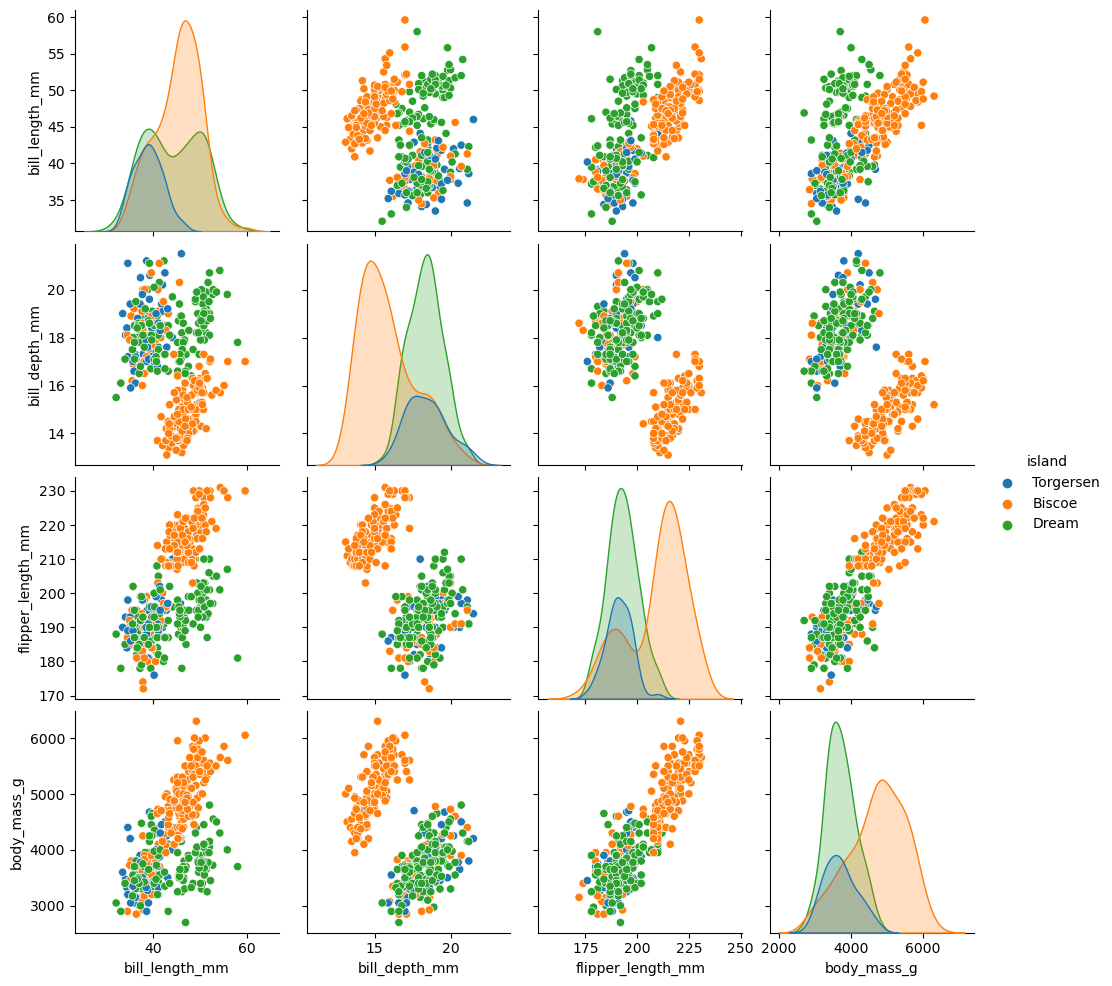

In [2]:
# Plot pairwise relationships in a dataset
# seaborn.pairplot(data, *, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)

penguins = sns.load_dataset("penguins")
sns.pairplot(data=penguins, hue="island")

In [3]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


## 3.3 Clustering with Dendrogram